In [17]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker
from torch_points3d.datasets.segmentation import IGNORE_LABEL
from torch_points3d.metrics.scannet_segmentation_tracker import ScannetSegmentationTracker

CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

import matplotlib.pyplot as plt 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def get_seen_points(mm_data):
    ### Select seen points
    csr_idx = mm_data.modalities['image'][0].view_csr_indexing
    dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
    # take subset of only seen points without re-indexing the same point
    mm_data = mm_data[dense_idx_list.unique()]
    return mm_data

def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

def get_random_view_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    selected_view_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        selected_idx = torch.randint(low=0, high=m2feats_of_seen_point.shape[0], size=(1,))
        selected_pred = m2feats_of_seen_point[selected_idx].squeeze(0)
        selected_view_preds.append(selected_pred)
    selected_view_preds = torch.stack(selected_view_preds, dim=0)
        
    return selected_view_preds


In [19]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/scratch-shared/fsun/dvata'



# print("Load MVFusion")
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f-no-transforms'   
# models_config = 'segmentation/multimodal/Feng/mvfusion_orig'    # model family
# model_name = 'MVFusion_orig'

print("Load MVFusion_3D")
dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f'   
models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
# model_name = 'MVFusion_3D_small_6views'                       # specific model
model_name = 'MVFusion_3D_small'


# print("Load DeepSet")
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f'   
# models_config = 'segmentation/multimodal/Feng/view_selection_experiment'    # model family
# model_name = 'DeepSetAttention'

# print("Load DeepSet_3D")
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f'   
# models_config = 'segmentation/multimodal/Feng/view_selection_experiment'    # model family
# model_name = 'Deepset_3D'


overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks
cfg.data.m2f_preds_dirname = 'ViT_masks'
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views

print("Set n_views to 9 for heatmap visualization!")
cfg.data.n_views = 9
print(cfg.data.n_views)

# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

Load MVFusion_3D
Set n_views to 9 for heatmap visualization!
9
Load predicted 2D semantic segmentation labels from directory  ViT_masks
initialize train dataset
initialize val dataset
Time = 8.0 sec.


In [20]:
from torch_points3d.models.model_factory import instantiate_model


# # MVFusion_orig
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/MVFusion_orig'

# # MVFusion_3D_small_6views
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/ViT_masks_3rd_run' # 3rd run

# MVFusion3D_small
checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-01-25/16-02-53'  # 9 views


# # DeepSetAttention
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-01-16/16-20-46'

# # DeepSet_3D
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/ViT_masks_DeepSet_3D'



# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
# print(model)

# Load the checkpoint and recover the 'best_miou' model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)

# Prepare the model for training
model = model.cuda()
print('Model loaded')

Creating model: MVFusion_3D_small
task:  segmentation.multimodal
tested_model_name:  MVFusion_3D_small
class_name:  MVFusionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d
name, cls of chosen model_cls:  MVFusionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d.MVFusionAPIModel'>
x feature dim:  {'FEAT': 3}
nc_in:  67
nc_in:  64
nc_in:  32
nc_in:  64
nc_in:  128
Return attention maps!
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  96
nc_in:  96
Model loaded


In [5]:
import pandas as pd


# Create validation loader
dataset.create_dataloaders(
    model,
    1,
    False,
    17,
    False,
    train_only=False,
    val_only=True,
    test_batch_size=1
)
tracker = ScannetSegmentationTracker(dataset=dataset, stage='val', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)


macc = TP / (TP + TN) $\rightarrow$ tells performance without accounting for false predictions

In [6]:
def add_dataframe_columns(batch, d):
    input_labels = batch.modalities['image'][0].get_mapped_m2f_features()
    csr_idx = batch.modalities['image'][0].view_csr_indexing

    # Set invalid views to NaN for analysis purposes
    pixel_validity = batch.data.mvfusion_input[:, :, 0] == 1

    input_labels = batch.data.mvfusion_input[:, :, -1]
    input_labels[~pixel_validity] = float('nan')

    num_views = pixel_validity.sum(dim=-1)

    input_labels_correct = torch.eq(input_labels, batch.y.unsqueeze(1))
    
    num_correct = input_labels_correct.sum(dim=1)
    num_incorrect = num_views - input_labels_correct.sum(dim=1)
    
    mode_pred = get_mode_pred(batch)


    d['n_views'] = num_views
    d['n_correct'] = num_correct
    d['n_incorrect'] = num_incorrect
    d['ref'] = batch.data.pred
    d['gt'] = batch.y
    d['ref==gt'] = d['ref'] == d['gt']
    d['ref_in_views'] = torch.eq(input_labels, batch.data.pred.unsqueeze(1)).sum(dim=1) >= 1
    d['gt_in_views'] = torch.eq(input_labels, batch.data.pred.unsqueeze(1)).sum(dim=1) >= 1
    d['mode'] = mode_pred

    for i in range(dataset.val_dataset.n_views):
        d[str(i+1)] = input_labels[:, i]

    return d

In [7]:
mapping_idx_to_names = dataset.val_dataset.MAPPING_IDX_TO_SCAN_VAL_NAMES

tracker.reset(stage='val')

rows_list = []
for batch in dataset._val_loader:
    print(batch.id_scan)
    
    # Inference
    model.set_input(batch, model.device)
    model(batch)
    batch.data.pred = model.output.detach().cpu().argmax(1)

    # Evaluate on seen points and valid gt only
    batch = get_seen_points(batch)
    batch = batch[batch.y != -1]

    tracker.track(pred_labels=batch.data.pred, gt_labels=batch.y, model=None)

    # Save for dataframe
    dict1 = {}
    dict1['scan_id'] = mapping_idx_to_names[batch.id_scan.item()]
    dict1['num_points'] = batch.num_points
#     dict1['miou'] = metrics['val_miou']
#     dict1['macc'] = metrics['val_macc']
#     dict1['acc'] = metrics['val_acc']
    
    add_dataframe_columns(batch, dict1)
    
    rows_list.append(dict1)
    
metrics = tracker.get_metrics()
print(metrics)


"DeepSet_3D: {'val_acc': 92.75101352769461, 'val_macc': 83.46320315814796, 'val_miou': 75.63078268111734}"
"MVFusion_3D: {'val_acc': 92.67111248661644, 'val_macc': 83.839164124908, 'val_miou': 75.67596747887866}"

df = pd.DataFrame(rows_list)
df

tensor([0])
tensor([1])
tensor([2])
tensor([3])
tensor([4])
tensor([5])
tensor([6])
tensor([7])
tensor([8])
tensor([9])
tensor([10])
tensor([11])
tensor([12])
tensor([13])
tensor([14])
tensor([15])
tensor([16])
tensor([17])
tensor([18])
tensor([19])
tensor([20])
tensor([21])
tensor([22])
tensor([23])
tensor([24])
tensor([25])
tensor([26])
tensor([27])
tensor([28])
tensor([29])
tensor([30])
tensor([31])
tensor([32])
tensor([33])
tensor([34])
tensor([35])
tensor([36])
tensor([37])
tensor([38])
tensor([39])
tensor([40])
tensor([41])
tensor([42])
tensor([43])
tensor([44])
tensor([45])
tensor([46])
tensor([47])
tensor([48])
tensor([49])
tensor([50])
tensor([51])
tensor([52])
tensor([53])
tensor([54])
tensor([55])
tensor([56])
tensor([57])
tensor([58])
tensor([59])
tensor([60])
tensor([61])
tensor([62])
tensor([63])
tensor([64])
tensor([65])
tensor([66])
tensor([67])
tensor([68])
tensor([69])
tensor([70])
tensor([71])
tensor([72])
tensor([73])
tensor([74])
tensor([75])
tensor([76])
tensor([7

,scan_id,num_points,n_views,n_correct,n_incorrect,ref,gt,ref==gt,ref_in_views,gt_in_views,1,2,3,4,5,6,7,8,9
0,scene0011_00,65917,"[tensor(1), tensor(1), tensor(2), tensor(5), t...","[tensor(1), tensor(1), tensor(2), tensor(4), t...","[tensor(0), tensor(0), tensor(0), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(1.), tensor(1.), tensor(1.), tensor(6....","[tensor(nan), tensor(nan), tensor(1.), tensor(...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor..."
1,scene0011_01,64825,"[tensor(1), tensor(9), tensor(9), tensor(5), t...","[tensor(1), tensor(8), tensor(8), tensor(4), t...","[tensor(0), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(1.), tensor(1.), tensor(1.), tensor(0....","[tensor(nan), tensor(1.), tensor(1.), tensor(1...","[tensor(nan), tensor(1.), tensor(1.), tensor(1...","[tensor(nan), tensor(1.), tensor(1.), tensor(1...","[tensor(nan), tensor(1.), tensor(1.), tensor(1...","[tensor(nan), tensor(1.), tensor(1.), tensor(n...","[tensor(nan), tensor(1.), tensor(0.), tensor(n...","[tensor(nan), tensor(0.), tensor(1.), tensor(n...","[tensor(nan), tensor(1.), tensor(1.), tensor(n..."
2,scene0015_00,60954,"[tensor(9), tensor(9), tensor(9), tensor(9), t...","[tensor(9), tensor(9), tensor(9), tensor(9), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(1.), tensor(1.), tensor(1.), tensor(1...."
3,scene0019_00,35645,"[tensor(2), tensor(1), tensor(1), tensor(1), t...","[tensor(2), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(True), tensor(True), tensor(True), ten...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(1.), tensor(nan), tensor(nan), tensor(...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor...","[tensor(nan), tensor(nan), tensor(nan), tensor..."
4,scene0019_01,40520,"[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1

In [16]:
n_correct_list = []
n_incorrect_list = []
ref_eq_gt_list = []
ref_list = []
gt_list = []
# mode_list = []

for d in rows_list:
    n_correct_list.extend(d['n_correct'].tolist())
    n_incorrect_list.extend(d['n_incorrect'].tolist())
    ref_eq_gt_list.extend(d['ref==gt'].tolist())
    ref_list.extend(d['ref'].tolist())
    gt_list.extend(d['gt'].tolist())
#     mode_list.extend(d['mode'].tolist())

In [17]:
def generate_heatmap(dataframe, evaluated_pred='ref==gt', title=None):
    """
    Creates a heatmap presenting the total number of occurences and the percentage of correctly predicted output.
    X-axis represents number of incorrect view-wise labels from the input Segmentation network
    Y-axis represents the number of correct view-wise labels
    
    input: dataframe with 'n_correct', 'n_incorrect' and an evaluated_pred column
    """
    matrix = dataframe[['n_correct', 'n_incorrect', evaluated_pred]].groupby(['n_correct','n_incorrect', evaluated_pred])[evaluated_pred].count()
    index = dataframe[['n_correct', 'n_incorrect']].groupby(['n_correct','n_incorrect']).count()
    index = list(index.axes[0])
    
    # Count positive and negative instances
    pos_counts = dict()
    neg_counts = dict()
    for idx in index:
        out = matrix[idx]
        out = list(out.items())
        bools, counts = list(map(list, zip(*out)))
        for i in range(len(bools)):
            if bools[i] == False:
                neg_counts[idx] = counts[i]
            elif bools[i] == True:
                pos_counts[idx] = counts[i]
    pos_array = np.zeros((10, 10)).astype(int)
    for k, v in pos_counts.items():
        pos_array[k] = v
    neg_array = np.zeros((10, 10)).astype(int)
    for k, v in neg_counts.items():
        neg_array[k] = v

    # Total number of occurences
    sum_matrix = pos_array + neg_array
    sum_matrix = np.flip(sum_matrix, axis=0)
    # Convert to percentage
    sum_matrix = sum_matrix / sum_matrix.sum()
        
    # Get precision
    cf_matrix = np.round(pos_array / (pos_array + (neg_array+1e-8)), 5)
    cf_matrix = np.flip(cf_matrix, axis=0)

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    sum_count = True
    percent = True
    blanks = ['' for i in range(sum_matrix.size)]

    group_labels = blanks

    if sum_count:
        group_counts = ["{0:0.2f}%\n".format(value*100) for value in sum_matrix.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:0.2f}%".format(value*100) for value in cf_matrix.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(sum_matrix.shape[0],sum_matrix.shape[1])

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=(12, 8))

    yticklabels = list(range(9, -1, -1))
    ax = sns.heatmap(cf_matrix, annot=box_labels, fmt="", yticklabels=yticklabels)
    ax.set(xlabel='Num Incorrect Views', ylabel='Num Correct Views')
    ax.set_title(title)

    plt.show()

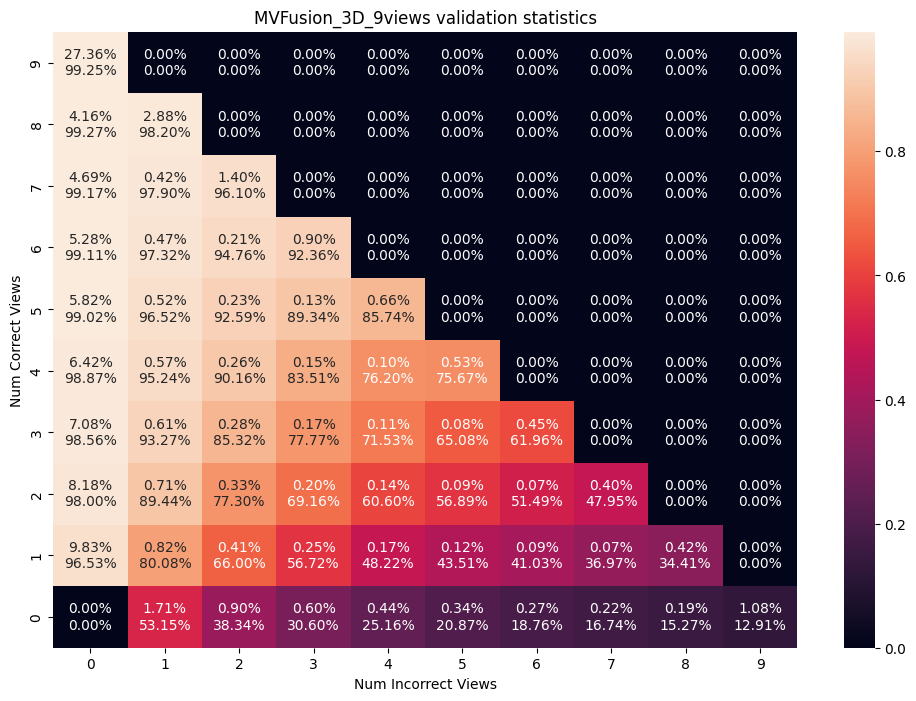

In [22]:
df_vis = pd.DataFrame(list(zip(n_correct_list, n_incorrect_list, ref_eq_gt_list, ref_list, gt_list)),#, mode_list)),
               columns =['n_correct', 'n_incorrect', 'ref==gt', 'ref', 'gt'])#, 'mode'])

# df_vis['mode==gt'] = df_vis['mode'] == df_vis['gt']

import seaborn as sns
generate_heatmap(df_vis, evaluated_pred='ref==gt', title='MVFusion_3D_9views validation statistics')

#### Descriptors for problem type
divide all points across class types
 or bucket number of views?

- number of views
- number of distinct input label clases
- number of correct label estimates
- number of incorrect label estimates
- refined outut label
- ground-truth label


- confusion matrix that accumulates all view preds, and one that accumulates refined pred x n views?

In [72]:
dict1 = {}
dict1['scan_id'] = mapping_idx_to_names[batch.id_scan.item()]
dict1['num_points'] = batch.num_points
dict1['miou'] = metrics['val_miou']
dict1['macc'] = metrics['val_macc']
dict1['acc'] = metrics['val_acc']
dict1[]

df = pandas.DataFrame(dict1)
df

KeyError: ''

In [24]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://kaldir.vc.in.tum.de/scannet_benchmark/img/legend.jpg")

# Viewing Conditions Ablation Study
- measure mIoU difference when setting each feature to its mean value

- Do this for MVFusion_3D, MVFusion and MVAttention!

    - First one because it is the general model,
    
      Second one because we remove the dependency of 3D Network on those features
      
      Third one because that truly shows the ability of each view condition to predict the quality of a view.

in 'mvfusion_input', this is the 2nd till 9th feature 

1. normalized depth
2. linearity
3. planarity
4. scattering
5. orientation to the surface
6. normalized pixel height
7. density
8. occlusion

In [9]:
# # means = []
# # n_points = []

# # for batch in dataset._val_loader:
# #     print(batch.id_scan)
# #     batch = batch    
# #     means.append(batch.modalities['image'][0]._mappings.values[2].mean(dim=0))
# #     n_points.append(batch.num_points)

# # means_tensor = torch.stack(means)
# # n_points_tensor = torch.tensor(n_points).unsqueeze(1)

# # weighted_mean = (means_tensor * n_points_tensor).sum(dim=0) / n_points_tensor.sum()

# # weighted_mean

# for split in ['train', 'val']:
#     data_dir = f"/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/processed/processed_2d_{split}"

#     mean = 0
#     std = 0
#     for name in os.listdir(data_dir):
#         print(name)
#         file = osp.join(data_dir, name)

#         data = torch.load(file)
#         data = data._mappings.values[2]

#         # note that estimation is biased
#         mean += data.mean(axis=0)
#         std += data.std(axis=0)
        
#     mean /= len(os.listdir(data_dir))
#     std /= len(os.listdir(data_dir))


#     print(f"{split} mapping feature statistics:")
#     print(mean)
#     print(std)    

In [7]:
# # Calculated from validation set
# weighted_mean = torch.tensor([0.2939, 0.1287, 0.7071, 0.1642, 0.6402, 0.4709, 0.2747, 0.6959])

# Calculated from training set
weighted_mean = torch.tensor([0.2711, 0.1401, 0.6778, 0.1822, 0.6568, 0.4669, 0.2979, 0.6933])

# mean tensor([0.2711, 0.1401, 0.6778, 0.1822, 0.6568, 0.4669, 0.2979, 0.6933])
# std  tensor([0.0811, 0.1083, 0.2375, 0.1710, 0.2294, 0.2735, 0.1378, 0.2283])

In [11]:
# trackers = [ScannetSegmentationTracker(dataset=dataset, stage='val', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
#                for i in range(8)]

# for t in trackers:
#     t.reset(stage='val')

    
for batch in dataset._val_loader:
    print(batch.id_scan)

    input_clone = batch.data.mvfusion_input.clone()
    
    for idx in range(8):
        # Change feature on idx to mean value
        batch.data.mvfusion_input = input_clone.clone()
        batch.data.mvfusion_input[:, :, idx+1] = weighted_mean[idx]

        # Inference
        model.set_input(batch, model.device)
        model(batch)
        batch.data.pred = model.output.detach().cpu().argmax(1)

        # Evaluate on seen points and valid gt only
        batch_seen_points = get_seen_points(batch)
        batch_seen_points = batch_seen_points[batch_seen_points.y != -1]

        trackers[idx].track(pred_labels=batch_seen_points.data.pred, gt_labels=batch_seen_points.y, model=None)

# metrics = []
# for idx in range(8):
#     cur_metrics = trackers[idx].get_metrics()
#     print(f"Set idx {idx} to mean value -> {cur_metrics}")
#     metrics.append(cur_metrics)

# print(metrics)

Set idx 0 to mean value -> {'val_acc': 92.8100074617039, 'val_macc': 83.76434573141195, 'val_miou': 76.09739709811365}
Set idx 1 to mean value -> {'val_acc': 92.81045516393802, 'val_macc': 83.75335646462987, 'val_miou': 76.00121341544657}
Set idx 2 to mean value -> {'val_acc': 92.82728350085591, 'val_macc': 83.74674970051613, 'val_miou': 76.09961606024771}
Set idx 3 to mean value -> {'val_acc': 92.82808234209718, 'val_macc': 83.81417291072675, 'val_miou': 76.13446451507045}
Set idx 4 to mean value -> {'val_acc': 92.77646490804547, 'val_macc': 83.67891266933984, 'val_miou': 75.90357335639615}
Set idx 5 to mean value -> {'val_acc': 92.81765351358469, 'val_macc': 83.90855134407738, 'val_miou': 76.12877418890314}
Set idx 6 to mean value -> {'val_acc': 92.83048764429618, 'val_macc': 83.7654629221649, 'val_miou': 76.13741819593211}
Set idx 7 to mean value -> {'val_acc': 92.80875213975332, 'val_macc': 83.7658742286463, 'val_miou': 75.97130328064831}
[{'val_acc': 92.8100074617039, 'val_macc': 

In [14]:
# Set idx 0 to mean value -> {'val_acc': 92.8100074617039, 'val_macc': 83.76434573141195, 'val_miou': 76.09739709811365}
# Set idx 1 to mean value -> {'val_acc': 92.81045516393802, 'val_macc': 83.75335646462987, 'val_miou': 76.00121341544657}
# Set idx 2 to mean value -> {'val_acc': 92.82728350085591, 'val_macc': 83.74674970051613, 'val_miou': 76.09961606024771}
# Set idx 3 to mean value -> {'val_acc': 92.82808234209718, 'val_macc': 83.81417291072675, 'val_miou': 76.13446451507045}
# Set idx 4 to mean value -> {'val_acc': 92.77646490804547, 'val_macc': 83.67891266933984, 'val_miou': 75.90357335639615}
# Set idx 5 to mean value -> {'val_acc': 92.81765351358469, 'val_macc': 83.90855134407738, 'val_miou': 76.12877418890314}
# Set idx 6 to mean value -> {'val_acc': 92.83048764429618, 'val_macc': 83.7654629221649, 'val_miou': 76.13741819593211}
# Set idx 7 to mean value -> {'val_acc': 92.80875213975332, 'val_macc': 83.7658742286463, 'val_miou': 75.97130328064831}
[{'val_acc': 92.8100074617039, 'val_macc': 83.76434573141195, 'val_miou': 76.09739709811365}, {'val_acc': 92.81045516393802, 'val_macc': 83.75335646462987, 'val_miou': 76.00121341544657}, {'val_acc': 92.82728350085591, 'val_macc': 83.74674970051613, 'val_miou': 76.09961606024771}, {'val_acc': 92.82808234209718, 'val_macc': 83.81417291072675, 'val_miou': 76.13446451507045}, {'val_acc': 92.77646490804547, 'val_macc': 83.67891266933984, 'val_miou': 75.90357335639615}, {'val_acc': 92.81765351358469, 'val_macc': 83.90855134407738, 'val_miou': 76.12877418890314}, {'val_acc': 92.83048764429618, 'val_macc': 83.7654629221649, 'val_miou': 76.13741819593211}, {'val_acc': 92.80875213975332, 'val_macc': 83.7658742286463, 'val_miou': 75.97130328064831}]

[{'val_acc': 92.8100074617039,
  'val_macc': 83.76434573141195,
  'val_miou': 76.09739709811365},
 {'val_acc': 92.81045516393802,
  'val_macc': 83.75335646462987,
  'val_miou': 76.00121341544657},
 {'val_acc': 92.82728350085591,
  'val_macc': 83.74674970051613,
  'val_miou': 76.09961606024771},
 {'val_acc': 92.82808234209718,
  'val_macc': 83.81417291072675,
  'val_miou': 76.13446451507045},
 {'val_acc': 92.77646490804547,
  'val_macc': 83.67891266933984,
  'val_miou': 75.90357335639615},
 {'val_acc': 92.81765351358469,
  'val_macc': 83.90855134407738,
  'val_miou': 76.12877418890314},
 {'val_acc': 92.83048764429618,
  'val_macc': 83.7654629221649,
  'val_miou': 76.13741819593211},
 {'val_acc': 92.80875213975332,
  'val_macc': 83.7658742286463,
  'val_miou': 75.97130328064831}]

In [6]:
tracker = ScannetSegmentationTracker(dataset=dataset, stage='val', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)

for batch in dataset._val_loader:
    print(batch.id_scan)

    # Inference
    model.set_input(batch, model.device)
    model(batch)
    batch.data.pred = model.output.detach().cpu().argmax(1)

    # Evaluate on seen points and valid gt only
    batch_seen_points = get_seen_points(batch)
#     batch_seen_points = batch_seen_points[batch_seen_points.y != -1]

    tracker.track(pred_labels=batch_seen_points.data.pred, gt_labels=batch_seen_points.y, model=None)
    
tracker.get_metrics()

tensor([0])
tensor([1])
tensor([2])
tensor([3])
tensor([4])
tensor([5])
tensor([6])
tensor([7])
tensor([8])
tensor([9])
tensor([10])
tensor([11])
tensor([12])
tensor([13])
tensor([14])
tensor([15])
tensor([16])
tensor([17])
tensor([18])
tensor([19])
tensor([20])
tensor([21])
tensor([22])
tensor([23])
tensor([24])
tensor([25])
tensor([26])
tensor([27])
tensor([28])
tensor([29])
tensor([30])
tensor([31])
tensor([32])
tensor([33])
tensor([34])
tensor([35])
tensor([36])
tensor([37])
tensor([38])
tensor([39])
tensor([40])
tensor([41])
tensor([42])
tensor([43])
tensor([44])
tensor([45])
tensor([46])
tensor([47])
tensor([48])
tensor([49])
tensor([50])
tensor([51])
tensor([52])
tensor([53])
tensor([54])
tensor([55])
tensor([56])
tensor([57])
tensor([58])
tensor([59])
tensor([60])
tensor([61])
tensor([62])
tensor([63])
tensor([64])
tensor([65])
tensor([66])
tensor([67])
tensor([68])
tensor([69])
tensor([70])
tensor([71])
tensor([72])
tensor([73])
tensor([74])
tensor([75])
tensor([76])
tensor([7

{'val_acc': 92.70142102750086,
 'val_macc': 83.95023708279729,
 'val_miou': 75.94783336623155}

# Below is a temporary cell to investigate the 9-correct views but incorrectly refined prediction problem

In [143]:
# n_correct_list = []
# n_incorrect_list = []
# ref_eq_gt_list = []
# ref_list = []
# gt_list = []
# # mode_list = []
# list_1 = []
# list_2 = []
# list_3 = []

# for d in rows_list:
#     n_correct_list.extend(d['n_correct'].tolist())
#     n_incorrect_list.extend(d['n_incorrect'].tolist())
#     ref_eq_gt_list.extend(d['ref==gt'].tolist())
#     ref_list.extend(d['ref'].tolist())
#     gt_list.extend(d['gt'].tolist())
# #     mode_list.extend(d['mode'].tolist())
#     list_1.extend(d['1'].tolist())
#     list_2.extend(d['2'].tolist())
#     list_3.extend(d['3'].tolist())


# df_vis = pd.DataFrame(list(zip(n_correct_list, n_incorrect_list, ref_eq_gt_list, ref_list, gt_list, list_1, list_2, list_3)),#, mode_list)),
#                columns =['n_correct', 'n_incorrect', 'ref==gt', 'ref', 'gt', '1', '2', '3'])#, 'mode'])

# df_vis

In [142]:
# df_vis['ref!=gt'] = ~df_vis['ref==gt']
# df_vis.sort_values(['n_correct', 'ref!=gt'], ascending=False)

In [141]:
# matrix = df_vis[['n_correct', 'ref', 'gt', 'ref!=gt']]
# matrix = matrix[matrix['n_correct'] == 9]
# matrix = matrix[matrix['ref!=gt'] == True]



# matrix = matrix.groupby(['gt', 'ref']).count()
# # index = df_vis[['n_correct', 'n_incorrect']].groupby(['n_correct','n_incorrect']).count()

# matrix

In [140]:
# index = list(matrix.axes[0])

# # Count positive and negative instances
# counts = dict()
# for idx in index:
#     out = matrix.loc[idx]
#     counts[idx] = out['n_correct']
    
# counts

In [144]:
# pos_array = np.zeros((20, 20)).astype(int)
# for k, v in counts.items():
#     pos_array[k] = v

# # Total number of occurences
# sum_matrix = pos_array
# sum_matrix = np.flip(sum_matrix, axis=0)
# # Convert to percentage
# sum_matrix = sum_matrix / sum_matrix.sum()

# # Get precision
# # cf_matrix = np.round(pos_array / (pos_array + (neg_array+1e-8)), 5)
# # cf_matrix = np.flip(cf_matrix, axis=0)

# # CODE TO GENERATE TEXT INSIDE EACH SQUARE
# sum_count = True
# percent = True
# blanks = ['' for i in range(sum_matrix.size)]

# group_labels = blanks
# group_counts = blanks

# if percent:
#     group_percentages = ["{0:0.2f}%".format(value*100) for value in sum_matrix.flatten()]
# else:
#     group_percentages = blanks

# box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
# box_labels = np.asarray(box_labels).reshape(sum_matrix.shape[0],sum_matrix.shape[1])

# # MAKE THE HEATMAP VISUALIZATION
# plt.figure(figsize=(16, 13))

# yticklabels = list(range(19, -1, -1))
# ax = sns.heatmap(sum_matrix, annot=box_labels, fmt="", yticklabels=yticklabels)
# ax.set(xlabel='Refined label', ylabel='GT label')
# ax.set_title('Case Study: 9 correct input views, incorrectly refined')

# plt.show()

In [145]:
# from IPython.display import Image
# from IPython.core.display import HTML 
# Image(url="https://kaldir.vc.in.tum.de/scannet_benchmark/img/legend.jpg")

In [139]:
# gt_1_ref_0_mask = (df_vis['n_correct'] == 9) & (df_vis['ref'] == 0) & (df_vis['gt'] == 1)
# df_vis[gt_1_ref_0_mask]

In [119]:
# df.num_points.cumsum()[:50]

# test_df = df.loc[23]

In [21]:
# scene0081_01
mm_data = dataset.val_dataset[23]

batch = MMBatch.from_mm_data_list([mm_data])
    
# Inference
model.set_input(batch, model.device)
model(batch)
batch.data.pred = model.output.detach().cpu().argmax(1)

batch.data.mode_pred = get_mode_pred(batch)

# Evaluate on seen points and valid gt only
batch = get_seen_points(batch)
batch = batch[batch.y != -1]





In [23]:
batch.modalities['image'] = None
visualize_mm_data(batch, class_names=CLASS_NAMES, class_colors=CLASS_COLORS, error_color=(0, 0, 0), front='y', back='m2f_pred_mask', figsize=1000, pointsize=3, voxel=0.05, show_2d=False, alpha=0.3)
